In [18]:
import datetime, warnings, scipy
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
#from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [20]:
### Preprocess

flights_train = pd.read_csv('Data/flights_train.csv', index_col=0)
flights_test = pd.read_csv('Data/flights_test.csv', index_col=0)

airlines = pd.read_csv('Data/airlines.csv', index_col=0)
airports = pd.read_csv('Data/airports.csv', index_col=0)

In [21]:
def conv_to_time(column):
    s = column.astype(int).astype(str).str.zfill(4)
    #add : twice
    column = s.str[:2] + ':' + s.str[2:] + ':00'
    
    return column

In [22]:
def add_dep_delay(scheduled,depart):
    
    tdelta = []
    FMT = '%H:%M:%S'

    for i in range(0,len(scheduled)):
        tdelta.append(datetime.strptime(depart.iloc[i], FMT) -
                      datetime.strptime(scheduled.iloc[i], FMT))


    for i in range(0,len(tdelta)):
        if (scheduled.iloc[i].startswith("00") & depart.iloc[i].startswith("23"))== True:
            tdelta[i] = timedelta(
            days=tdelta[i].days,
            seconds= tdelta[i].seconds - 24*60*60,
            microseconds=tdelta[i].microseconds
        )
        elif (scheduled.iloc[i].startswith("23") & depart.iloc[i].startswith("0"))==True:
            tdelta[i] = timedelta(
            days=0,
            seconds= tdelta[i].seconds,
            microseconds=tdelta[i].microseconds
        )
        if tdelta[i].days < 0:
            tdelta[i] = (tdelta[i].seconds - 24*60*60)/60
        else:
            tdelta[i] = (tdelta[i].seconds)/60

    return tdelta

In [23]:
flights_train["DEPARTURE_TIME1"]  = conv_to_time(flights_train["DEPARTURE_TIME"])
flights_train["SCHEDULED_DEPARTURE1"]  = conv_to_time(flights_train["SCHEDULED_DEPARTURE"])

flights_train["DEPARTURE_TIME1"] = flights_train["DEPARTURE_TIME1"].replace('24:00:00','00:00:00')

flights_train["DEPARTURE_DELAY"] = add_dep_delay(flights_train["SCHEDULED_DEPARTURE1"],flights_train["DEPARTURE_TIME1"])

flights_train.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,DEPARTURE_TIME1,SCHEDULED_DEPARTURE1,DEPARTURE_DELAY
id,,,,,,,,,,,,,,,,,,,,
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,21.0,15.0,205.0,1448,430,-22.0,23:54:00,00:05:00,-11.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,12.0,14.0,280.0,2330,750,-9.0,00:02:00,00:10:00,-8.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,16.0,34.0,286.0,2296,806,5.0,00:18:00,00:20:00,-2.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,15.0,30.0,285.0,2342,805,-9.0,00:15:00,00:20:00,-5.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,11.0,35.0,235.0,1448,320,-21.0,00:24:00,00:25:00,-1.0


In [24]:
flights_test["DEPARTURE_TIME1"]  = conv_to_time(flights_test["DEPARTURE_TIME"])
flights_test["SCHEDULED_DEPARTURE1"]  = conv_to_time(flights_test["SCHEDULED_DEPARTURE"])

flights_test["DEPARTURE_TIME1"] = flights_test["DEPARTURE_TIME1"].replace('24:00:00','00:00:00')

flights_test["DEPARTURE_DELAY"] = add_dep_delay(flights_test["SCHEDULED_DEPARTURE1"],flights_test["DEPARTURE_TIME1"])

#### Save pickle

In [26]:
flights_train.to_pickle('flights_train.pickle')

In [27]:
flights_test.to_pickle('flights_test.pickle')

#### Read pickle

In [ ]:
flights_train = pd.read_pickle('flights_train.pickle')

In [ ]:
flights_test = pd.read_pickle('flights_test.pickle')

## Correlation departure/arrival delays

In [29]:
train_set = flights_train

<AxesSubplot:xlabel='DEPARTURE_DELAY', ylabel='ARRIVAL_DELAY'>

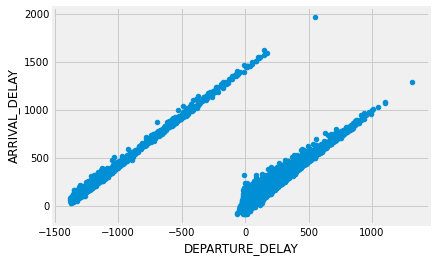

In [30]:
train_set.plot.scatter(
    x="DEPARTURE_DELAY", 
    y="ARRIVAL_DELAY"
)

In [96]:
DEPARTURE_DELAY_pos = train_set[train_set['DEPARTURE_DELAY'] >= -100]
DEPARTURE_DELAY_pos = DEPARTURE_DELAY_pos[DEPARTURE_DELAY_pos['ARRIVAL_DELAY'] < 1200]

DEPARTURE_DELAY_neg = train_set[train_set['DEPARTURE_DELAY'] < -100]
DEPARTURE_DELAY_neg = DEPARTURE_DELAY_neg[DEPARTURE_DELAY_neg['ARRIVAL_DELAY'] > 210]

<AxesSubplot:xlabel='DEPARTURE_DELAY', ylabel='ARRIVAL_DELAY'>

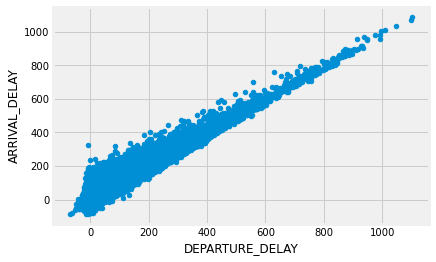

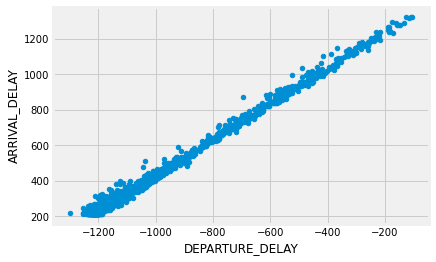

In [97]:
DEPARTURE_DELAY_pos.plot.scatter(
    x="DEPARTURE_DELAY", 
    y="ARRIVAL_DELAY"
)

DEPARTURE_DELAY_neg.plot.scatter(
    x="DEPARTURE_DELAY", 
    y="ARRIVAL_DELAY"
)


In [98]:
from sklearn.linear_model import LinearRegression

In [99]:
model_lin = LinearRegression()

x_pos = np.array(DEPARTURE_DELAY_pos['DEPARTURE_DELAY']).reshape(-1, 1)
y_pos = np.array(DEPARTURE_DELAY_pos['ARRIVAL_DELAY']).reshape(-1, 1)
model_pos = model_lin.fit(x_pos, y_pos)

r_sq_pos = model_pos.score(x_pos, y_pos)
print('coefficient of determination:', r_sq_pos)
print('intercept:', model_pos.intercept_[0])
print('slope:', model_pos.coef_[0][0])

coefficient of determination: 0.8777586688871325
intercept: -4.388372521216417
slope: 1.010119953283392


In [100]:
model_lin = LinearRegression()

x_neg = np.array(DEPARTURE_DELAY_neg['DEPARTURE_DELAY']).reshape(-1, 1)
y_neg = np.array(DEPARTURE_DELAY_neg['ARRIVAL_DELAY']).reshape(-1, 1)
model_neg = model_lin.fit(x_neg, y_neg)

r_sq_neg = model_neg.score(x_neg, y_neg)
print('coefficient of determination:', r_sq_neg)
print('intercept:', model_neg.intercept_[0])
print('slope:', model_neg.coef_[0][0])

coefficient of determination: 0.9950897504396532
intercept: 1440.7279236010413
slope: 1.0068662405614168


### Predict

In [101]:
flights_test_pos = flights_test[flights_test['DEPARTURE_DELAY'] >= -100]
flights_test_neg = flights_test[flights_test['DEPARTURE_DELAY'] < -100]

In [102]:
x_pos = flights_test_pos['DEPARTURE_DELAY']
x_neg = flights_test_neg['DEPARTURE_DELAY']

In [103]:
y_pred_pos = model_pos.predict(pd.DataFrame(x_pos))
y_pred_neg = model_neg.predict(pd.DataFrame(x_neg))

In [104]:
y_pred_pos = pd.DataFrame(y_pred_pos, index=x_pos.index)
y_pred_neg = pd.DataFrame(y_pred_neg, index=x_neg.index)

In [105]:
# Combine the 2 predictions
y_pred = pd.concat([y_pred_pos, y_pred_neg])
y_pred = y_pred.sort_index()

In [107]:
y_pred.to_csv("submission_linear.csv")

Score with linear model: **165.96464**

## More thoughts

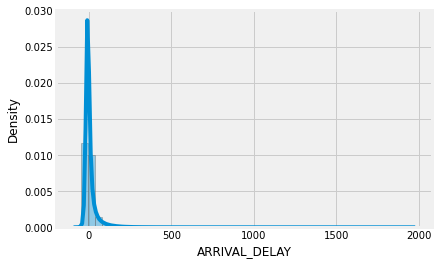

In [108]:
sns.distplot(flights_train['ARRIVAL_DELAY']);

In [125]:
flights_train['ARRIVAL_DELAY_log'] = flights_train['ARRIVAL_DELAY'].apply(lambda x: np.log(88+x))

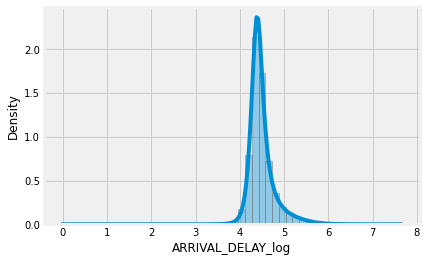

In [127]:
sns.distplot(flights_train['ARRIVAL_DELAY_log']);